# GCN

## Load data

In [45]:
import os
from pathlib import Path
import pickle

PATH = '' # os.path.join(Path.cwd().parents[2], '')

with open(os.path.join(PATH, "graphs_for_leak.pkl"), "rb") as f:
    mint_graphs, mint_labels = pickle.load(f)

with open(os.path.join(PATH, "graphs_for_limit.pkl"), "rb") as f:
    limit_graphs, limit_labels = pickle.load(f)

with open(os.path.join(PATH, "graphs_for_leak.pkl"), "rb") as f:
    leak_graphs, leak_labels = pickle.load(f)

### sample

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

In [47]:
def show_sample(name, graphs, labels):
    for i, (graph, label) in enumerate(zip(graphs, labels)):
        nx.draw(graph, with_labels=True, node_color='lightblue', node_size=200, edge_color='gray', font_size=5)
        plt.title(f"Graph {i}, {name}: {label[0]}")
        plt.show()
        if i == 2:
            break

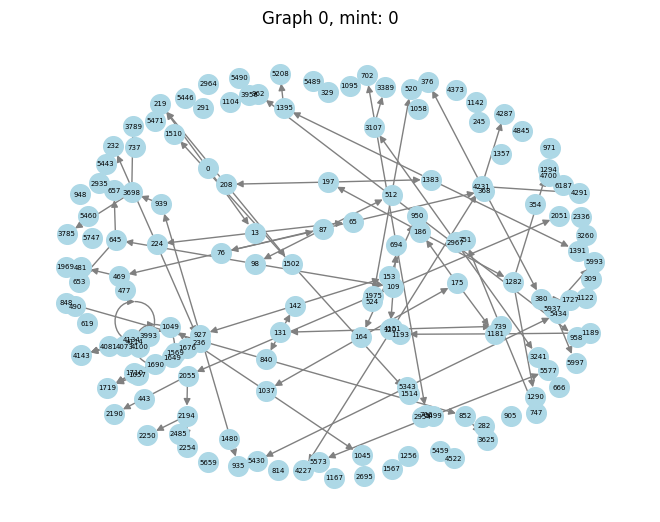

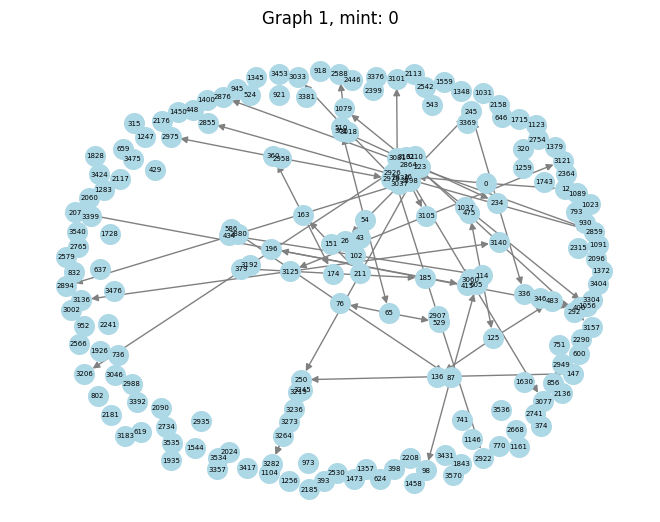

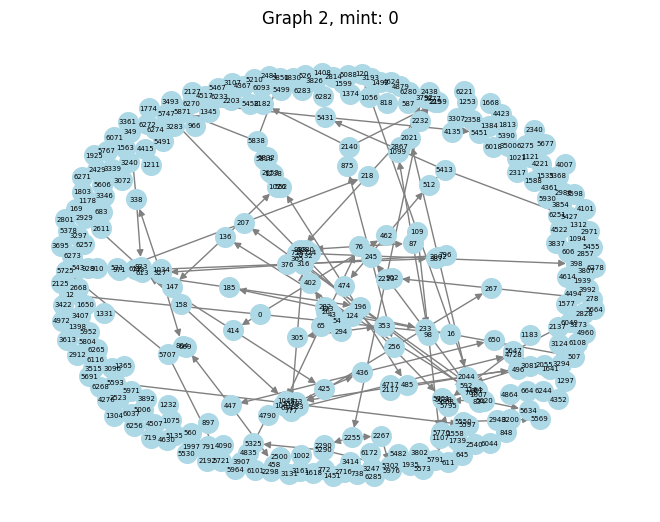

In [48]:
show_sample('mint', mint_graphs, mint_labels)

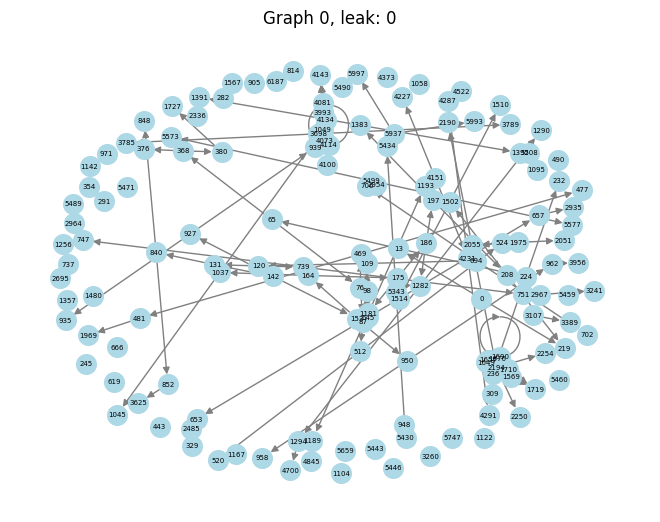

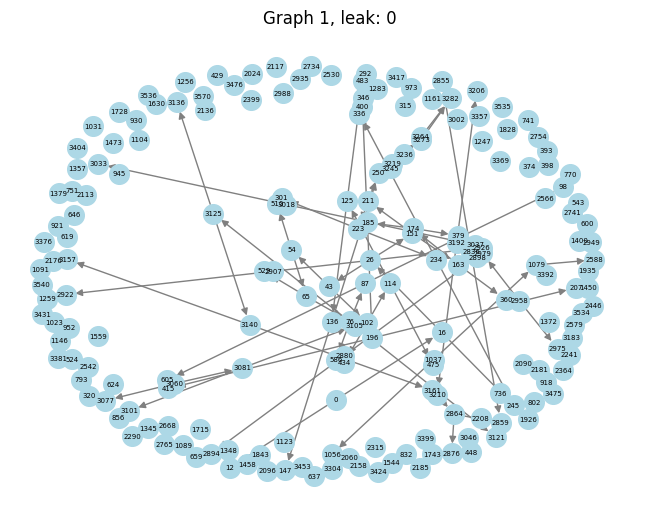

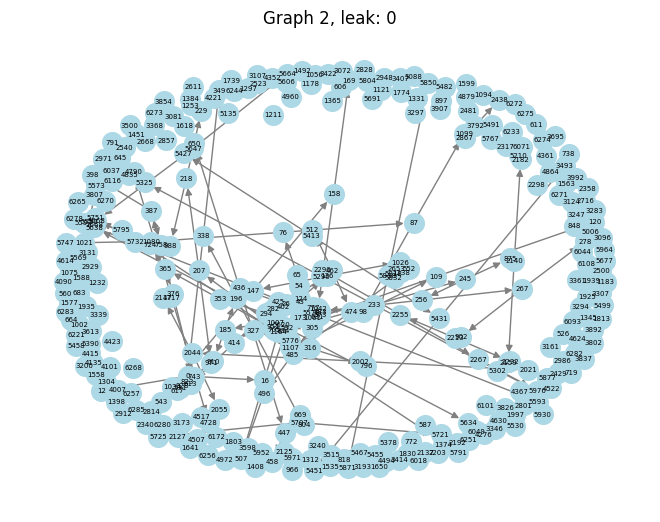

In [49]:
show_sample('leak', leak_graphs, leak_labels)

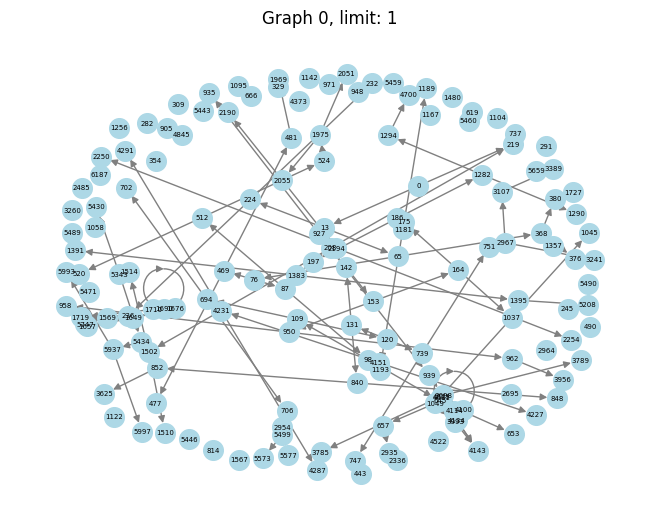

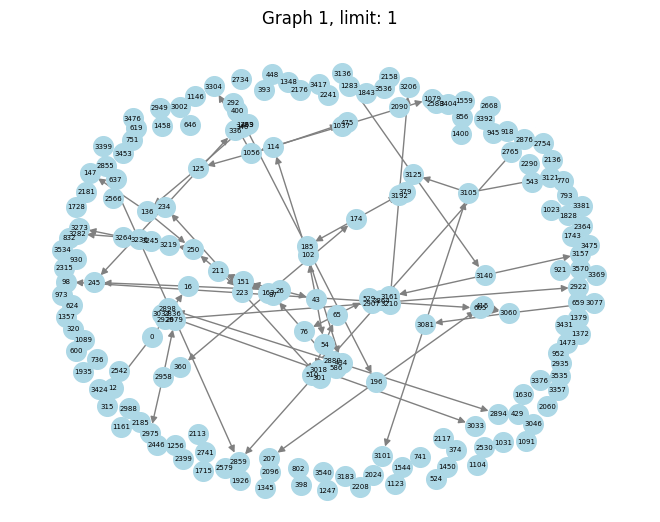

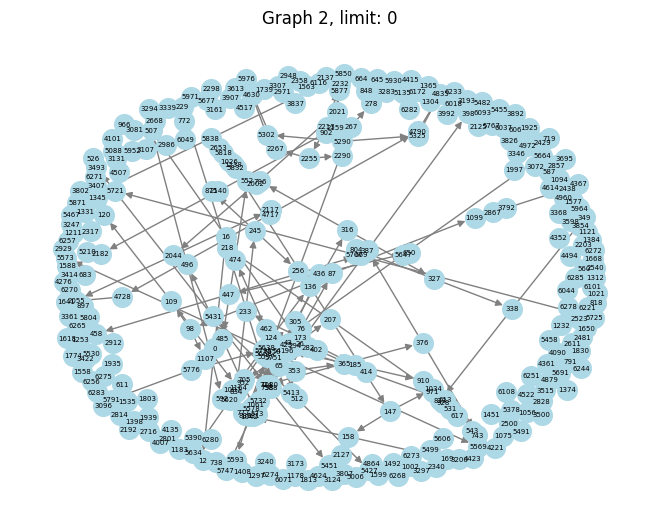

In [50]:
show_sample('limit', limit_graphs, limit_labels)

## Install required packages.

In [54]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip uninstall torch torch-scatter torch-sparse torch-geometric -y
!pip install torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.6.0+cu124
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torch_scatter 2.1.2+pt26cu124
Uninstalling torch_scatter-2.1.2+pt26cu124:
  Successfully uninstalled torch_scatter-2.1.2+pt26cu124
Found existing installation: torch_sparse 0.6.18+pt26cu124
Uninstalling torch_sparse-0.6.18+pt26cu124:
  Successfully uninstalled torch_sparse-0.6.18+pt26cu124
Found existing installation: torch-geometric 2.7.0
Uninstalling torch-geometric-2.7.0:
  Successfully uninstalled torch-geometric-2.7.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Using cached https://data.pyg.org/whl/torch-2.6.0%2Bcu124/torch_scatter-2.1.2%2Bpt26cu124-cp311-cp311-linux_x86_64.whl (10.8 MB)


KeyboardInterrupt: 

In [ ]:
def extract_graph_features(G):
    return {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "density": nx.density(G),
        "connected_components": nx.number_weakly_connected_components(G),
        "avg_clustering": nx.average_clustering(G.to_undirected())
    }


In [53]:
import torch
from torch_geometric.utils import from_networkx

def create_dataset(graphs, labels):
    dataset = []

    for graph, label in zip(graphs, labels):
        data = from_networkx(graph)
        label_value = [l for l in label.values()]
        features = extract_graph_features(graph)
        degrees = torch.tensor([d for _, d in graph.degree()], dtype=torch.float).unsqueeze(1)

        # Concatenate node degrees with graph-level features for each node
        graph_features_tensor = torch.tensor(list(features.values()), dtype=torch.float).unsqueeze(0).repeat(data.num_nodes, 1)
        data.x = torch.cat([degrees, graph_features_tensor], dim=1)


        data.y = torch.tensor(label_value, dtype=torch.float).unsqueeze(0)
        # data.x = torch.tensor([d for _, d in graph.degree()]+ list(features.values()), dtype=torch.float).unsqueeze(1)
        # data.x = degrees
        print(data)
        dataset.append(data)
    return dataset

AttributeError: partially initialized module 'torch_geometric' has no attribute 'typing' (most likely due to a circular import)

In [ ]:
from torch_geometric.data import DataLoader

# Data Loader
mint_dataset = create_dataset(mint_graphs, mint_labels)
leak_dataset = create_dataset(leak_graphs, leak_labels)
limit_dataset = create_dataset(limit_graphs, limit_labels)
mint_loader = DataLoader(mint_dataset, batch_size=32, shuffle=True)
leak_loader = DataLoader(leak_dataset, batch_size=32, shuffle=True)
limit_loader = DataLoader(limit_dataset, batch_size=32, shuffle=True)